In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_curve, auc
import ipywidgets as widgets
from IPython.display import display, HTML
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from IPython.display import HTML

In [2]:
# Load and preprocess the data
file_path = 'cyberbullying_tweets.csv'
data = pd.read_csv(file_path, header=None, names=['tweet', 'cyberbullying_type'])


    # Define words to be removed for each category
words_to_remove = {
    'not_cyberbullying': ['bullying'],
    'religion': ['fuck'], 
    'other_cyberbullying': ['https', 'co', 'time', 't', 'rt', 'mkr', 'people', 
                            'love', 'now', 'make', 'hi', 'hello', 'pretty']
        # Add more categories and words as needed
    }

# Function to remove hashtags and Twitter handles
def clean_text(text):
    # Remove Twitter handles (e.g., @username)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s,]', '', text)  # Removes all non-word characters except spaces and commas
    # Optionally, remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to clean text based on category
def clean_text_by_category(text, category):

    remove_words = words_to_remove.get(category, [])
    # Create a regex pattern for the words to remove
    pattern = r'\b(?:' + '|'.join(map(re.escape, remove_words)) + r')\b'
    # Remove the words from the text
    text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    return text

# Apply the cleaning function to the tweet_text column
data['tweet'] = data['tweet'].apply(clean_text)

# Apply the cleaning function to the 'tweet' column based on the 'cyberbullying_type' category
data['tweet'] = data.apply(lambda row: clean_text_by_category(row['tweet'], row['cyberbullying_type']), axis=1)

#pick an amount of data to sample
data = data.sample(n=5000, random_state=15)

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['cyberbullying_type'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['label'], test_size=0.2, random_state=6)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train the SVM model
svm_model = SVC(max_iter=5000, kernel='linear', random_state=42, probability=True)
svm_model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_vectorized)

# Moderator Shield V.01 🤬

In [24]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['cyberbullying_type'])
# Get the class labels

#Defines what happens when you click the button
def on_click_predict(b):
    comment_vectorized = vectorizer.transform([comment_widget.value])# Predict probabilities for a specific input
    prediction = svm_model.predict(comment_vectorized)
    button_output.value='Prediction = '+ str(label_encoder.inverse_transform([prediction[0]])[0])
    
    # Predict probabilities for a specific input
    predicted_probabilities = svm_model.predict_proba(comment_vectorized)[0]  # Get the first row of probabilities
    class_labels = label_encoder.inverse_transform(np.arange(len(predicted_probabilities)))

    # Plotting a bar chart for predicted probabilities
    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, predicted_probabilities)
    plt.xlabel('Class Labels')
    plt.ylabel('Predicted Probability')
    plt.title('Prediction Probabilities for the Input')
    plt.xticks(rotation=45)  # Rotate labels if needed
    plt.show()

#The text boxes where the user can input values.
comment_widget = widgets.Text(description='Comment:', placeholder='Enter Comment Here', label='Comment')


#A button for the user to get classification prediction
button_predict = widgets.Button( description='Classify Comment' )
button_output = widgets.Label(value='Preparing crystal ball...' )

button_predict.on_click(on_click_predict)

#Displays the text boxes and buttons inside a VBox
vb=widgets.VBox([comment_widget, button_predict, button_output])

display(HTML("<h5 style='font-size:13px;'>1. Enter a comment.</h5>"))
display(HTML("<h5 style='font-size:13px;'>2. Press the \"Classify Comment\" button.</h5>"))
display(HTML("<h5 style='font-size:13px;'>3. Watch the magic happen! </h5>"))

display(vb)

###### Categories are Age 🎂, Religion 🕊️, Ethnicity 🌎, Gender 🧑‍🤝‍🧑, Not, and Other

## Statistics Visualized
(For more on this, refer to the proposal under Visualizations)

In [3]:
# Generate a classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")

# Function to make predictions on new data
def predict_cyberbullying(new_tweets):
    new_tweets_vectorized = vectorizer.transform(new_tweets)
    predictions = svm_model.predict(new_tweets_vectorized)
    return label_encoder.inverse_transform(predictions)
    
# Example usage of the prediction function
new_tweets = [
    "You're such an idiot, nobody likes you!",
    "Great job on your presentation today!",
    "I hope you die in a fire, loser."
]

predictions = predict_cyberbullying(new_tweets)
for tweet, prediction in zip(new_tweets, predictions):
    print(f"Tweet: {tweet}")
    print(f"Prediction: {prediction}\n")

Classification Report:
                     precision    recall  f1-score   support

                age       0.91      0.98      0.95       161
          ethnicity       0.96      0.99      0.97       155
             gender       0.93      0.84      0.88       162
  not_cyberbullying       0.64      0.51      0.56       176
other_cyberbullying       0.61      0.75      0.67       169
           religion       0.92      0.90      0.91       177

           accuracy                           0.82      1000
          macro avg       0.83      0.83      0.82      1000
       weighted avg       0.82      0.82      0.82      1000

Accuracy: 0.82

Tweet: You're such an idiot, nobody likes you!
Prediction: religion

Tweet: Great job on your presentation today!
Prediction: not_cyberbullying

Tweet: I hope you die in a fire, loser.
Prediction: other_cyberbullying



#### The model has a high level of accuracy overall at 82% in the prototype phase. 

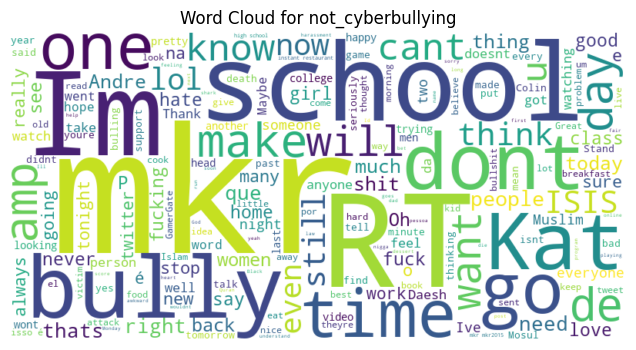

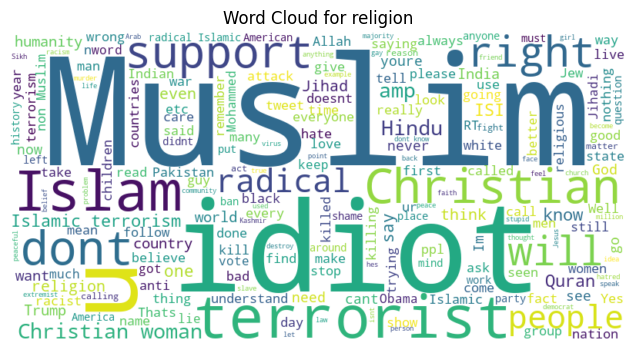

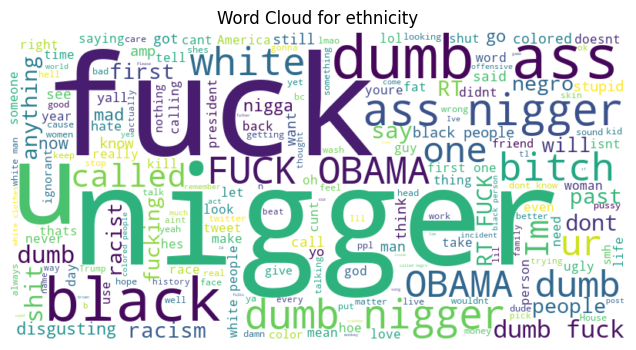

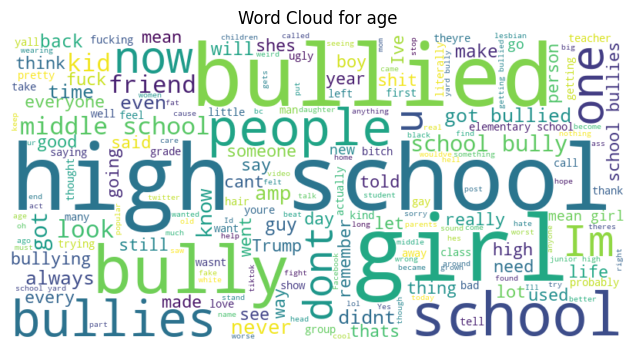

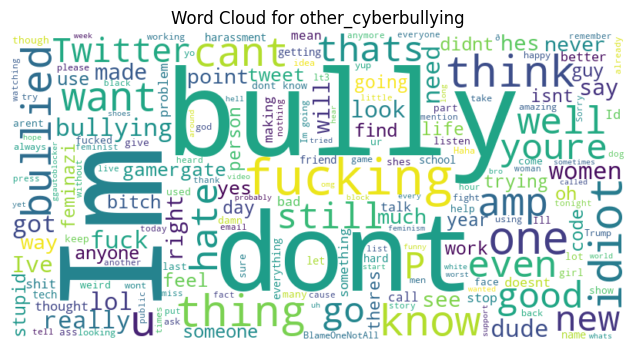

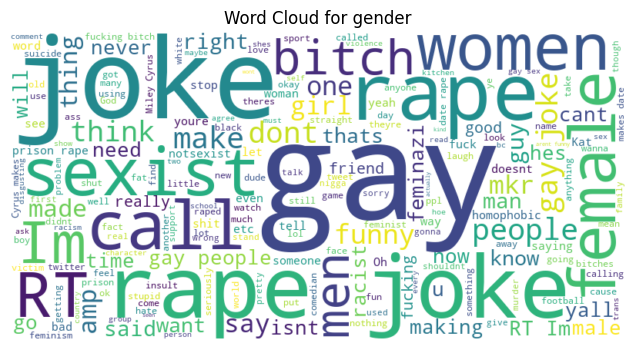

In [3]:
# Function to get word frequencies for a specific category and generate a word cloud
def create_word_cloud(data, category):
    text = ' '.join(data[data['cyberbullying_type'] == category]['tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category}')
    plt.axis('off')
    plt.show()

# Generate word clouds for each category
for category in data['cyberbullying_type'].unique():
    create_word_cloud(data, category)

#### These word clouds let you visualize how your model sees your classifications and allow you to adjust accordingly.

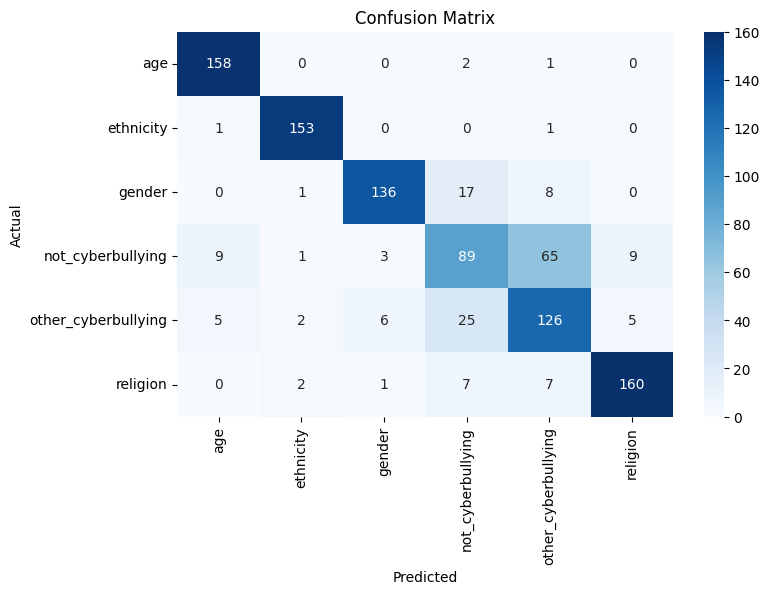

In [4]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### This confusion matrix elegantly provides an inside look into the testing process. It includes how many classifications 
#### the model got right (true positives) as well as wrong (false positives) and what category was alternatively selected.

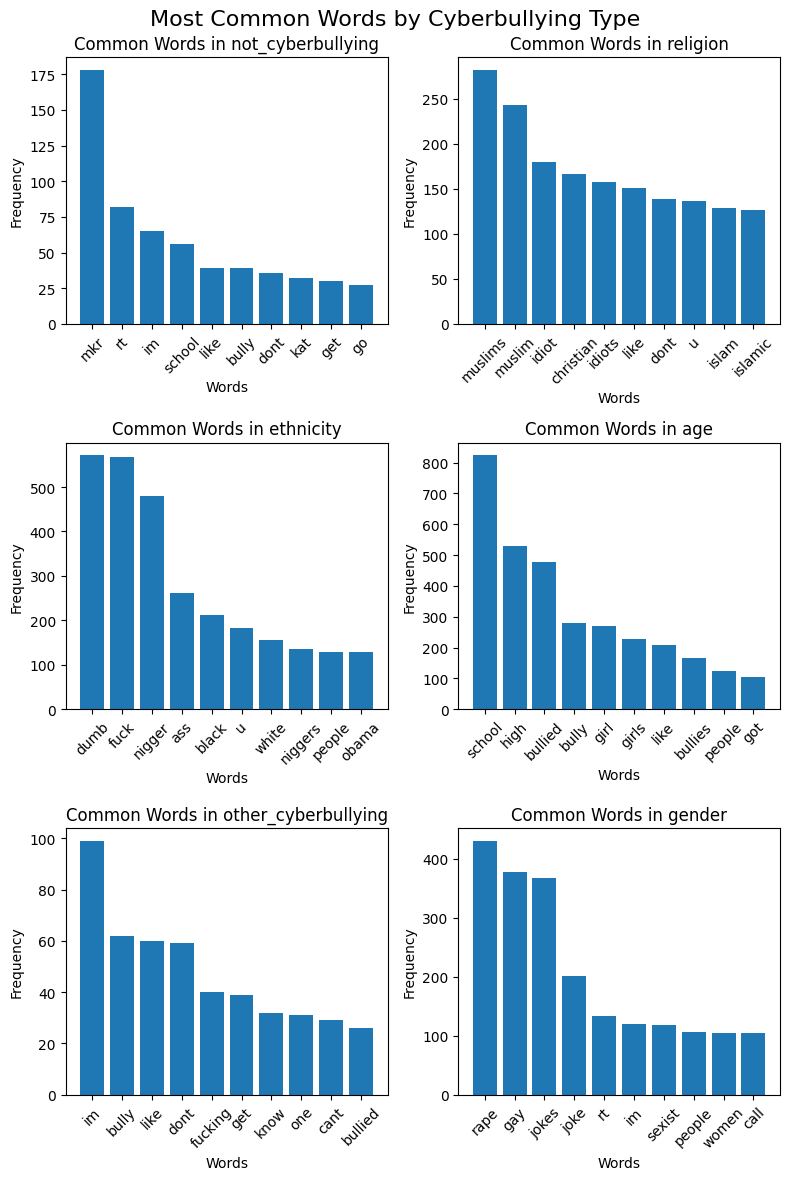

In [9]:
# Load stop words
stop_words = set(stopwords.words('english'))

def preprocess_tweet(tweet):
    # Remove special characters and numbers
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    # Convert to lowercase and tokenize
    words = word_tokenize(tweet.lower())
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)  # Return a string instead of a list

data['processed_tweets'] = data['tweet'].apply(preprocess_tweet)

# Function to get word frequencies for a specific category
def get_word_freq(data, category):
    all_words = ' '.join(data[data['cyberbullying_type'] == category]['processed_tweets'])
    words = all_words.split()  # Split into words correctly
    return Counter(words)

# Get word frequencies for each category
word_freq = {category: get_word_freq(data, category) for category in data['cyberbullying_type'].unique()}

# Number of top words to display
n_top_words = 10

# Create subplots for word frequencies
n_categories = len(word_freq)
fig, axes = plt.subplots(nrows=(n_categories + 1) // 2, ncols=2, figsize=(8, 2 * n_categories))
fig.suptitle('Most Common Words by Cyberbullying Type', fontsize=16)

axes = axes.flatten()

for i, (category, freq) in enumerate(word_freq.items()):
    top_words = freq.most_common(n_top_words)
    words, counts = zip(*top_words)

    axes[i].bar(words, counts)
    axes[i].set_title(f'Common Words in {category}')
    axes[i].set_xlabel('Words')
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### These bar graphs present the words most frequently associated with the different classifications in a classic, easily interpretable way.

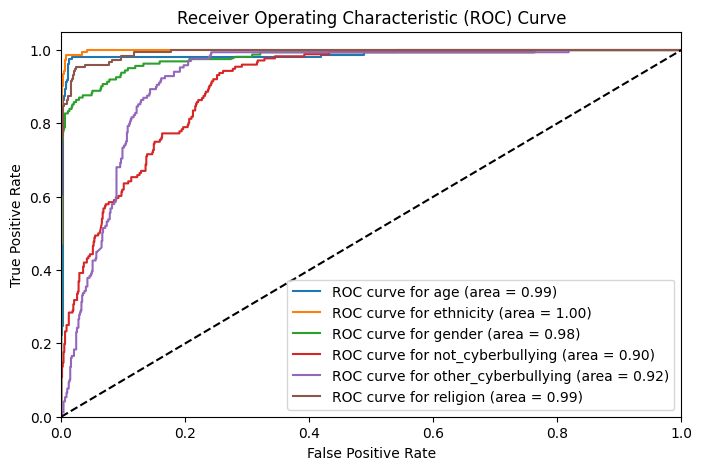

In [10]:
# Compute ROC curve and ROC area for each class
y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
y_score = svm_model.predict_proba(X_test_vectorized)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 5))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

%matplotlib tk

#### This ROC graph provides a snapshot of the model's prediction performance by category.